### Import libraries

In [61]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import gensim.downloader as api
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from gensim import models, corpora
from gensim.models import WordEmbeddingSimilarityIndex
from gensim.matutils import cossim
from gensim.similarities import SparseTermSimilarityMatrix
from sklearn.metrics import confusion_matrix,classification_report

### Load pre-trained word embedding model

In [2]:
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
#glove_model50 = api.load("glove-wiki-gigaword-50")

### Define function to clean text (removing stopwords, lemmatization, stemming)

In [3]:
STOPWORDS = stopwords.words('english')

# remove additional generic words
STOPWORDS = STOPWORDS + ['also','anything','area','around','ask','back','bad','basic','better','bit','cant',
                         'complaint','cost','could','day','didnt','disgusting','dont','even','ever','everything',
                         'extra','feel','get','good','great','horrible','hotel','hour','leave','like','line',
                         'little','look','money','much','need','never','new','night','nothing','ok','old','one',
                         'option','overall','paid','pay','per','picture','place','price','quite','rate','really',
                         'recommend','said','say','see','service','stay','stayed','sure','terrible','thing',
                         'think','time','time','told','took','turn','u','use','want','wasnt','way','well','went',
                         'work','worst','worth','would']

# initialize lemmatizer and stemmer
wn_lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [wn_lemmatizer.lemmatize(p_stemmer.stem(t)) for t in tokenized_text if t not in STOPWORDS]
    return cleaned_text

### Import negative sentences dataset

In [4]:
df_negative_sentences = pd.read_csv('./datasets/df_negative_sentences.csv',lineterminator='\n')

### Remove empty reviews

In [5]:
df_negative_sentences = df_negative_sentences[~pd.isnull(df_negative_sentences['review_sentence'])]

### Identify set of topics and topic keywords

In [6]:
room_comfort_topic = 'Noise noisy loud slam voice music thin wall hear' + ' Smell smelly odor stink' + ' Ac heat hot cold thermostat air vent ventilation fan adjust heater temperature'
staff_topic = 'Staff rude unfriendly friendly polite front desk manager maid reception valet clerk housekeep waiter waitress' + ' Check checkin checkout communication experience bag early late reservation booking'
breakfast_topic = 'Breakfast food egg bacon sausage toast potato waffle fruit omelette omelet cheese milk pastry coffee tea juice silverware plasticware cup plastic included selection taste fresh'
facilities_topic = 'Facility elevator lift stair wheelchair pool jacuzzi gym vending spa sauna renovation bar restaurant lounge pet property' + ' WiFi internet connection' + ' Park lot car valet street'
location_topic = 'Location surrounding far traffic highway walk street road neighborhood sketchy attraction center city town downtown nearby near walk transport subway park view safe dangerous drive'
bathroom_topic = 'Bathroom shower tub bathtub drain curtain pressure sink water toiletry toilet mirror shampoo conditioner towel soap ply paper hair face wash vent ventilation fan window'
room_amenities_topic = 'Room carpet curtain shade drape light outlet plug window tv balcony couch remote wall fridge refrigerator safe machine coffee tea kettle amenity microwave card door'
bed_quality_topic = 'Bed thin sheet linen blanket cover comforter pillow hard soft firm mattress bug bedbug king double queen twin frame sleep pullout couch bunk comfortable flat'

topics= [room_comfort_topic,staff_topic,breakfast_topic,facilities_topic,location_topic,bathroom_topic,room_amenities_topic,bed_quality_topic]
n_topics = len(topics)

In [34]:
# old set of topic keywords

# room_comfort_topic = 'Noise noisy loud quiet party slam scream yell voice music sound thin wall hear talk' + 'Smell smelly smoke odor cigarette stink' + 'Ac heat heaterac hot cold warm chilly thermostat cool air conditioning vent ventilation fan adjust heater temperature'
# staff_topic = 'Staff rude unfriendly friendly polite impolite front desk manager maid reception valet clerk reception housekeep waiter waitress' + 'Check in out checkin checkout communication experience bag early late reservation booking'
# breakfast_topic = 'Breakfast food egg bacon sausage toast waffle fruit omelette omelet cheese milk pastry coffee tea juice silverware plasticware cup plastic included selection taste fresh'
# facilities_topic = 'Facility elevator work lift stair floor disability wheelchair pool jacuzzi gym vending machine spa towel sauna renovation bar restaurant lounge pet friendly dinner lunch pit property' + 'WiFi wi fi internet slow connection signal fast spotty' + 'Park lot car valet street driveway'
# location_topic = 'Location surrounding far traffic highway walk street road neighborhood sketchy attraction center city town downtown nearby near walk transport subway park view safe dangerous drive'
# bathroom_topic = 'Bathroom stain shower tub bathtub drain curtain pressure sink water toiletry toilet mirror shampoo conditioner towel soap ply paper hair hand face wash vent ventilation fan window'
# room_amenities_topic = 'Room tiny small big large spacious stain carpet curtain shade drape light view outlet plug window tv balcony couch service remote wall fridge refrigerator safe machine coffee tea kettle amenity microwave card door'
# bed_quality_topic = 'Bed stain sheet linen blanket cover comforter pillow hard soft mattress bug bedbug king double queen frame'

# topics= [room_comfort_topic,staff_topic,breakfast_topic,facilities_topic,location_topic,bathroom_topic,room_amenities_topic,bed_quality_topic]
# n_topics = len(topics)

### Tokenize sentences into words and clean text

In [7]:
tokenized_neg_data = []
for text in df_negative_sentences['review_sentence']:
    tokenized_neg_data.append(clean_text(text))
    
tokenized_topics = []    
for text in topics:
    tokenized_topics.append(clean_text(text))
    
tokenized_neg_data_and_topics = tokenized_neg_data + tokenized_topics

### Build dictionary

In [8]:
neg_dictionary = corpora.Dictionary(tokenized_neg_data_and_topics)

### Create BoW vectors

In [9]:
corpus_neg_data = [neg_dictionary.doc2bow(text) for text in tokenized_neg_data]
corpus_neg_topics = [neg_dictionary.doc2bow(text) for text in tokenized_topics]

### Build similarity matrix of word embeddings from model

In [10]:
termsim_index = WordEmbeddingSimilarityIndex(fasttext_model300)
similarity_matrix = SparseTermSimilarityMatrix(termsim_index,neg_dictionary)

### Compute (soft) cosine similarity between sentences and topics

In [11]:
neg_data_topics = []
for review_item in corpus_neg_data:
    review_item_topics = []
    for topic in corpus_neg_topics:
        # using BoW vectors (cosine similarity)
        #review_item_topics.append(cossim(review_item,topic))
        # using BoW + word embeddings (soft cosine similarity)
        review_item_topics.append(similarity_matrix.inner_product(review_item,topic,normalized=True))
    neg_data_topics.append(review_item_topics)

### Extract topic with highest (soft) cosine similarity
- We set a minimum threshold (0.05) that needs to be reached in order to assign a topic
- If above-threshold topics are within 0.002, we assign -1 (i.e. no main topic)

In [12]:
neg_data_closest_topic = []
cossim_threshold = 0.05

for review_item_topic_list in neg_data_topics:
    if max(review_item_topic_list)>cossim_threshold:
        review_item_array = np.array(review_item_topic_list)
        sorted_review_item_array = sorted(review_item_array,reverse=True)
        num_topics=1
        for item in sorted_review_item_array[1:]:
            if abs(item-sorted_review_item_array[0])<0.002:
                num_topics+=1
        if num_topics==1:
            neg_data_closest_topic.append(np.argmax(review_item_topic_list))
        else:
            neg_data_closest_topic.append(-1)
            #num_topics*=(-1)
            #closest_topics = sorted(list(review_item_array.argsort()[num_topics:][::-1])) 
            #neg_data_closest_topic.append(closest_topics)
    else:
        neg_data_closest_topic.append(-1)

### Assign extracted topic

In [13]:
df_negative_sentences['review_topic'] = neg_data_closest_topic

In [78]:
# visualize distribution of topics across corpus
df_negative_sentences['review_topic'].value_counts()

-1    54422
 6    52701
 5    25216
 1    24565
 7    18235
 2    18063
 3    17588
 0    15167
 4    12231
Name: review_topic, dtype: int64

### Construct pivot table of hotels (index), topics (columns), and topic counts (values)

In [20]:
df_negative_sentences_by_topic = df_negative_sentences.groupby(['hotel_url','review_topic']).size().reset_index()
df_negative_sentences_by_topic.rename({0:'review_topic_count'},axis=1,inplace=True)

In [21]:
df_negative_sentences_by_topic_pt = df_negative_sentences_by_topic.pivot_table(values='review_topic_count',index='hotel_url',columns='review_topic').reset_index()
df_negative_sentences_by_topic_pt.fillna(0,inplace=True)

### Normalize each count by total number of negative sentences per hotel

In [22]:
df_negative_sentences_count_by_hotel = df_negative_sentences.groupby('hotel_url').count().reset_index()[['hotel_url','review_topic']]
df_negative_sentences_count_by_hotel.rename({'review_topic':'sentences_count'},axis=1,inplace=True)

In [23]:
df_negative_sentences_by_topic_pt = df_negative_sentences_by_topic_pt.merge(df_negative_sentences_count_by_hotel,on='hotel_url')

In [24]:
# obtaining number of tagged negative sentences for normalization
#df_negative_sentences_by_topic_pt['sentences_count']=df_negative_sentences_by_topic_pt['sentences_count']-df_negative_sentences_by_topic_pt[-1]
#df_negative_sentences_by_topic_pt = df_negative_sentences_by_topic_pt[df_negative_sentences_by_topic_pt['sentences_count']!=0.0]

### Create columns with normalized topic counts

In [25]:
df_negative_sentences_by_topic_pt[[str(n)+'_pc' for n in range(-1,n_topics)]] = df_negative_sentences_by_topic_pt[[n for n in range(-1,n_topics)]].div(df_negative_sentences_by_topic_pt.sentences_count, axis=0)

### Write pivot table out to csv

In [26]:
df_negative_sentences_by_topic_pt.to_csv('./datasets/df_negative_sentences_by_topic_pt_we.csv',index=False)

### Validate topic extraction against manually-annotated entries

In [27]:
df_negative_sentences_annotated = pd.read_csv('./datasets/df_negative_sentences_annotated.csv',lineterminator='\n')

In [28]:
# changing notation from old numbering of topics to new numbering

# part 1 of notation changing
df_negative_sentences_annotated['review_topic_annotated']=df_negative_sentences_annotated['review_topic_annotated'].replace(4,3)
df_negative_sentences_annotated['review_topic_annotated']=df_negative_sentences_annotated['review_topic_annotated'].replace(5,0)
df_negative_sentences_annotated['review_topic_annotated']=df_negative_sentences_annotated['review_topic_annotated'].replace(6,0)
df_negative_sentences_annotated['review_topic_annotated']=df_negative_sentences_annotated['review_topic_annotated'].replace(7,3)
df_negative_sentences_annotated['review_topic_annotated']=df_negative_sentences_annotated['review_topic_annotated'].replace(9,1)

# part 2 of notation changing
df_negative_sentences_annotated['review_topic_annotated']=df_negative_sentences_annotated['review_topic_annotated'].replace(8,4)
df_negative_sentences_annotated['review_topic_annotated']=df_negative_sentences_annotated['review_topic_annotated'].replace(10,5)
df_negative_sentences_annotated['review_topic_annotated']=df_negative_sentences_annotated['review_topic_annotated'].replace(11,6)
df_negative_sentences_annotated['review_topic_annotated']=df_negative_sentences_annotated['review_topic_annotated'].replace(12,7)

In [29]:
# keeping only relevant columns
df_negative_sentences_annotated = df_negative_sentences_annotated[['review_date','review_sentence','review_topic_annotated']]

In [30]:
# merging dataframes and keeping only entries with manually-annotated topic
df_negative_sentences_topic_validation = df_negative_sentences.merge(df_negative_sentences_annotated,on=['review_date','review_sentence'])
df_negative_sentences_topic_validation = df_negative_sentences_topic_validation[~pd.isnull(df_negative_sentences_topic_validation['review_topic_annotated'])]
df_negative_sentences_topic_validation['review_topic_annotated'] = df_negative_sentences_topic_validation['review_topic_annotated'].apply(lambda x:int(x))

In [31]:
# classification report on manually-annotated data
print(classification_report(df_negative_sentences_topic_validation['review_topic_annotated'],df_negative_sentences_topic_validation['review_topic']))

              precision    recall  f1-score   support

          -1       0.95      0.81      0.88       152
           0       0.72      0.49      0.58        37
           1       0.64      0.70      0.67        23
           2       0.83      0.96      0.89        26
           3       0.86      0.65      0.74        48
           4       0.54      0.67      0.60        21
           5       0.79      0.97      0.87        35
           6       0.52      0.74      0.61        46
           7       0.72      1.00      0.84        23

    accuracy                           0.77       411
   macro avg       0.73      0.78      0.74       411
weighted avg       0.80      0.77      0.78       411



### Create f1-score dataframe for slides

In [55]:
f1_score_dict = {'topic': ['no main topic','bathroom','bed quality','breakfast','facilities',
                           'location','room amenities','room comfort','staff'],
                 'f1-score': [0.88,0.87,0.84,0.89,0.74,0.60,0.61,0.58,0.67]}
f1_score_df = pd.DataFrame.from_dict(f1_score_dict)

In [56]:
f1_score_df

,topic,f1-score
0,no main topic,0.88
1,bathroom,0.87
2,bed quality,0.84
3,breakfast,0.89
4,facilities,0.74
5,location,0.60
6,room amenities,0.61
7,room comfort,0.58
8,staff,0.67


### Create topic pie chart for slides

In [70]:
df_topic_counts = df_negative_sentences['review_topic'].value_counts().rename_axis('Topic').reset_index(name='Count')
df_topic_counts.replace(-1,'no main topic',inplace=True)
df_topic_counts.replace(0,'room comfort',inplace=True)
df_topic_counts.replace(1,'staff',inplace=True)
df_topic_counts.replace(2,'breakfast',inplace=True)
df_topic_counts.replace(3,'facilities',inplace=True)
df_topic_counts.replace(4,'location',inplace=True)
df_topic_counts.replace(5,'bathroom',inplace=True)
df_topic_counts.replace(6,'room amenities',inplace=True)
df_topic_counts.replace(7,'bed quality',inplace=True)

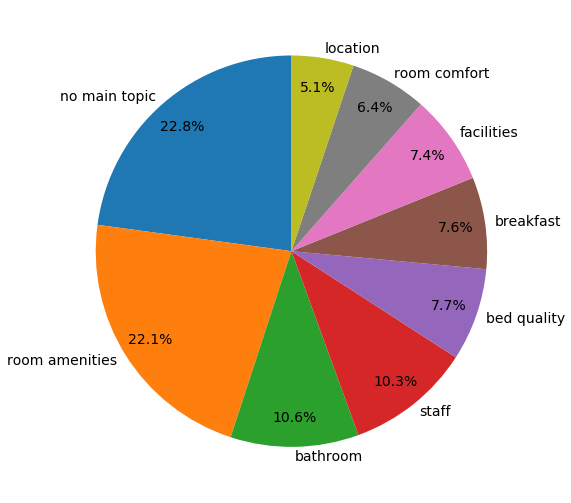

In [83]:
plt.figure(figsize=(9,9))
df_topic_counts['Count'].plot(kind='pie', labels=df_topic_counts['Topic'], autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.05, startangle=90, shadow=False, legend = False, fontsize=14)
plt.axis('off')
plt.show()

## First approach: LDA topic modeling

In [57]:
# set number of topics
NUM_TOPICS = 8

In [58]:
# build the LDA model (multicore)
lda_model = models.LdaMulticore(corpus=corpus_neg_data, num_topics=NUM_TOPICS, id2word=neg_dictionary)

In [59]:
# print most representative words from extracted topics
for idx in range(NUM_TOPICS):
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 5))

Topic #0: 0.060*"staff" + 0.020*"wall" + 0.017*"rude" + 0.016*"help" + 0.014*"bed"
Topic #1: 0.151*"room" + 0.073*"small" + 0.043*"bathroom" + 0.014*"dirti" + 0.014*"facil"
Topic #2: 0.055*"bed" + 0.050*"shower" + 0.031*"water" + 0.028*"bathroom" + 0.017*"hot"
Topic #3: 0.082*"room" + 0.030*"smell" + 0.025*"towel" + 0.019*"noisi" + 0.019*"window"
Topic #4: 0.048*"room" + 0.022*"book" + 0.015*"pool" + 0.012*"bed" + 0.011*"cold"
Topic #5: 0.101*"breakfast" + 0.036*"room" + 0.033*"coffe" + 0.020*"poor" + 0.016*"food"
Topic #6: 0.039*"check" + 0.031*"door" + 0.029*"room" + 0.026*"desk" + 0.023*"front"
Topic #7: 0.069*"clean" + 0.064*"room" + 0.027*"elev" + 0.022*"park" + 0.021*"dirti"


In [64]:
corpus_neg_data_lda_output = lda_model[corpus_neg_data]

In [ ]:
neg_data_closest_topic = []
for review_item in corpus_neg_data_lda_output:
    review_item_sorted = sorted(review_item,key=lambda x:-x[1])
    if review_item_sorted[0][1]>cossim_threshold:
        neg_data_closest_topic.append(review_item_sorted[0][0])
    else:
        neg_data_closest_topic.append(-1)